In [1]:
# Initialize jupyter
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sympy import *
import numpy as np
import pylab
init_printing()

# Forward kinematics

In [3]:
l1, l2, l3 = symbols('l_1 l_2 l_3', real=True)
alpha, beta, gamma, delta = symbols('alpha beta gamma delta', real=True)

In [5]:
# alpha = q1
# beta = q2
q1 = alpha
q2 = beta

x = l1 * cos(alpha) + l2 * cos(alpha + beta)
y = l1 * sin(alpha) + l2 * sin(alpha + beta)

In [6]:
P = Matrix([x, y])
P

⎡l₁⋅cos(α) + l₂⋅cos(α + β)⎤
⎢                         ⎥
⎣l₁⋅sin(α) + l₂⋅sin(α + β)⎦

In [7]:
J = P.jacobian([alpha, beta])
J

⎡-l₁⋅sin(α) - l₂⋅sin(α + β)  -l₂⋅sin(α + β)⎤
⎢                                          ⎥
⎣l₁⋅cos(α) + l₂⋅cos(α + β)   l₂⋅cos(α + β) ⎦

In [8]:
# Convert the Jacobian to a numerical version
Jnum = lambdify((alpha, beta, l1, l2), J, 'numpy')

In [9]:
# Evaluate the jacobian around singularity, in normal working regime and define a force vector
Jnormal = Jnum(0.230, -0.2, 86, 72)
Jsingular = Jnum(1e-3, 1e-3, 86, 72)
F = np.array([1, 0])

# Jacobian Inverse method

According to Buss (2009) this sucks big times

In [10]:
JI = lambda J, F: np.linalg.inv(J) @ F

In [11]:
JI(Jnormal, F)

array([-0.05850261,  0.12657122])

In [12]:
JI(Jsingular, F)

array([ 11.62788566, -25.51676992])

In [13]:
# Here is why it is a problem: the condition number of the matrix gets huge around the singularity:
print(np.linalg.cond(Jnormal))
print(np.linalg.cond(Jsingular))

24.2654911349
4868.86265519


# Dampled least square

This should be a bit better around oscillations

In [20]:
DLS_damp = lambda J, F, damping: J.T @ np.linalg.inv((J @ J.T + damping ** 2 * np.eye(2))) @ F

Text(0.5,1,'Torque error for DLS')

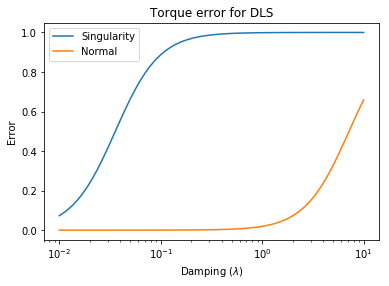

In [21]:
Damping = np.logspace(-2, 1, num=100)
err_sing = lambda l: np.linalg.norm(Jsingular @ DLS_damp(Jsingular, F, l) - F)
err_norm = lambda l: np.linalg.norm(Jnormal @ DLS_damp(Jnormal, F, l) - F)

plt.semilogx(Damping, np.array([err_sing(s) for s in Damping]))
plt.semilogx(Damping, np.array([err_norm(s) for s in Damping]))
plt.legend(['Singularity', 'Normal'])
plt.xlabel('Damping ($\lambda$)')
plt.ylabel('Error')
plt.title('Torque error for DLS')

# Comparison of results

0.24989705376


Text(0.5,1,'Torque around singularity, $\\lambda = 2.0$')

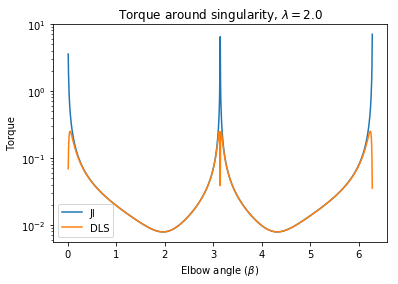

In [24]:
damping = 2
DLS = lambda J, F: J.T @ np.linalg.inv((J @ J.T + damping ** 2 * np.eye(2))) @ F
Beta = np.linspace(0.00, 2 * 3.14, num=1000)

def JI_safe(J, F):
    try:
        return JI(J, F)
    except:
        return float('nan')
    
torque_JI = lambda beta: np.linalg.norm(JI_safe(Jnum(0, beta, 100, 100), F))
torque_JI = np.vectorize(torque_JI)

torque_DLS = lambda beta: np.linalg.norm(DLS(Jnum(0, beta, 100, 100), F))
torque_DLS = np.vectorize(torque_DLS)

plt.semilogy(Beta, np.array([torque_JI(b) for b in Beta]))
plt.semilogy(Beta, np.array([torque_DLS(b) for b in Beta]))

print(np.max(np.array([torque_DLS(b) for b in Beta])))

plt.legend(('JI', 'DLS'))
plt.xlabel('Elbow angle ($\\beta$)')
plt.ylabel('Torque')
#plt.ylim(-0.1, 1)
plt.title('Torque around singularity, $\\lambda = {:.1f}$'.format(damping))

# Useful numerical values for testing

In [28]:
DLS(Jnum(0.2, -0.2, 100, 200), np.array([1, 1]))

array([-0.04867114,  0.07751386])

In [29]:
DLS(Jnum(0.2e-3, -0.2e-3, 100, 200), np.array([1, 1]))

array([ 0.00076903,  0.00384607])

# References
Buss, S. R. Introduction to inverse kinematics with jacobian transpose, pseudoinverse and damped least squares methods, 2009. Typeset manuscript from: http://math.ucsd.edu/~sbuss/ResearchWeb.